In [4]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
from basilisk import Node, BN

In [5]:
# define nodes/edges

C = Node("cloudy")
R = Node("rain", [C])  # each node knows its parent
S = Node("sprinkler", [C])
W = Node("wet", [R, S])

ls_n = [C, R, S, W]

In [6]:
# fetch joint observations
obs = pd.read_csv("data/observations.csv").drop("Unnamed: 0", axis=1)
obs.head()

,cloudy,rain,sprinkler,wet
0,True,True,False,True
1,False,False,False,False
2,False,True,False,True
3,False,False,False,False
4,False,False,False,False


In [7]:
# construct model with nodes and observations
model = BN(ls_n, obs)

In [9]:
# we could inspect each node's children
model.dict_adj

{'cloudy': ['rain', 'sprinkler'],
 'rain': ['wet'],
 'sprinkler': ['wet'],
 'wet': []}

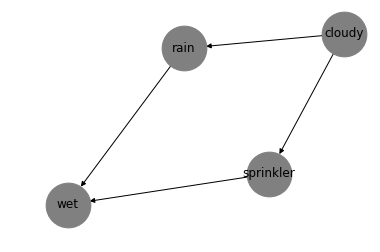

In [11]:
# visualize
model.draw_graph(node_size=2000, node_color='gray')

In [12]:
# easily view conditional probabilities for each node
model.generate_cpt("sprinkler")

sprinkler,cloudy,False,True
0,False,0.496855,0.503145
1,True,0.892925,0.107075
